# Variability analysis

An important tool in analyzing the behavior of computational models is analyzing the sensitivity of results to parameter changes. Metabolic Control Analysis (MCA) provides tools for analyzing the effects of such changes on the steady state of the model.

In [54]:
from __future__ import print_function, division
%matplotlib inline

import roadrunner
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

We are interested in the effects of parameters for a given simulation scenario. The analysed scenario is simple simulation to steady state.

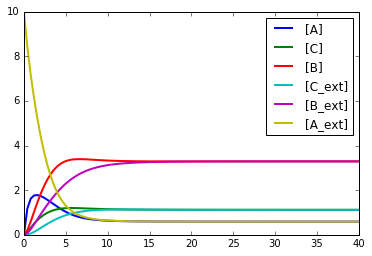

A = 0.592003505368
C = 1.11845145729
B = 3.28951210037
C_ext = 1.11846859027
B_ext = 3.28944074703
A_ext = 0.592123599679


In [55]:
# from multiscale.examples.testdata import demo_filepath
demo_filepath="demo_v02.xml"

# equidistant timecourse
roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, True)
rr = roadrunner.RoadRunner(demo_filepath)
s = rr.simulate(0,40, 100, plot=True)  

for sid, value in zip(rr.model.getFloatingSpeciesIds(), rr.model.getFloatingSpeciesConcentrations()):
    print('{} = {}'.format(sid, value))

In [56]:
# Steady States
# Performs a steady state calculation (evolves the system to a steady
#        state), then calculates and returns the set of values specified by
#        the steady state selections.
print(rr.selections)
print(rr.getSteadyStateValues())

['time', '[A]', '[C]', '[B]', '[C_ext]', '[B_ext]', '[A_ext]']
[ 0.59210528  1.11842109  3.28947379  1.11842105  3.28947388  0.59210491]


## Metabolic Control Analysis (MCA)

Metabolic control analysis (MCA) is a mathematical framework for describing metabolic, signaling, and genetic pathways. MCA quantifies how variables, such as fluxes and species concentrations, depend on network parameters. In particular it is able to describe how network dependent properties, called control coefficients, depend on local properties called elasticities [http://en.wikipedia.org/wiki/Metabolic_control_analysis].

### Control Coefficients

A control coefficient measures the relative steady state change in a system variable, e.g. pathway flux (J) or metabolite concentration (S), in response to a relative change in a parameter, e.g. enzyme activity or the steady-state rate ( v_i ) of step i. The two main control coefficients are the flux and concentration control coefficients. Flux control coefficients are defined by:

$$C^J_{v_i} = \left( \frac{dJ}{dp} \frac{p}{J} \right) \bigg/ \left( \frac{\partial v_i}{\partial p}\frac{p}{v_i} \right) = \frac{d\ln J}{d\ln v_i}$$

In [57]:
# Scaled control coefficient with respect to a global parameter.
rr.getCC('bA', 'Vmax_bA')

0.05554890329514592

In [58]:
# The n by n matrix of scaled flux control coefficients 
# where n is the number of reactions.
print('** Scaled Flux Control Coefficients **')
rr.getScaledFluxControlCoefficientMatrix()
C_J = DataFrame(rr.getScaledFluxControlCoefficientMatrix(), \
                index=rr.model.getReactionIds(), \
                columns=rr.model.getReactionIds())
print(C_J)

** Scaled Flux Control Coefficients **


RuntimeError: Unexpected error from getScaledFluxControlCoefficientMatrix()Dividing with zero

and concentration control coefficients by:

$$C^S_{v_i} = \left( \frac{dS}{dp} \frac{p}{S} \right) \bigg/ \left( \frac{\partial v_i}{\partial p} \frac{p}{v_i} \right) = \frac{d\ln S}{d\ln v_i}$$

In [59]:
# The m by n matrix of scaled concentration control coefficients where m is the number
# of floating species and n the number of reactions.
print('** Scaled Concentration Control Coefficients **')
C_S = DataFrame(rr.getScaledConcentrationControlCoefficientMatrix(), \
                index=rr.model.getFloatingSpeciesIds(), \
                columns=rr.model.getReactionIds())
print(C_S)

** Scaled Concentration Control Coefficients **
                 bA  bB  bC        v1        v2        v3        v4
A      6.661339e-17  -0  -0 -0.292398 -0.223684  0.422515  0.093567
C      6.661339e-17  -0  -0 -0.030960  0.188080 -0.355263  0.198142
B      6.661339e-17  -0  -0  0.063158 -0.023684  0.044737 -0.084211
C_ext  6.661339e-17  -0   0 -0.030960  0.188080 -0.355263  0.198142
B_ext  6.661339e-17   0  -0  0.063158 -0.023684  0.044737 -0.084211
A_ext -1.058413e-15  -0  -0 -0.292398 -0.223684  0.422515  0.093567


### Summation Theorems

The flux control summation theorem was discovered independently by the Kacser/Burns group and the Heinrich/Rapoport group in the early 1970s and late 1960s. The flux control summation theorem implies that metabolic fluxes are systemic properties and that their control is shared by all reactions in the system. When a single reaction changes its control of the flux this is compensated by changes in the control of the same flux by all other reactions.

$$\sum_i C^J_{v_i} = 1$$

$$\sum_i C^S_{v_i} = 0$$

In [60]:
# Flux control coefficients have to sum to 1
print(np.sum(C_J, axis=1))
abs(np.sum(C_J, axis=1)-1) < 1E-6

NameError: name 'C_J' is not defined

In [61]:
# Concentration control coefficients have to sum to 0
print(np.sum(C_S, axis=1))
np.sum(C_S, axis=1) < 1E-6

A        1.665335e-16
C       -5.551115e-17
B        6.938894e-17
C_ext   -5.551115e-17
B_ext    9.714451e-17
A_ext   -8.743006e-16
dtype: float64


A        True
C        True
B        True
C_ext    True
B_ext    True
A_ext    True
dtype: bool

### Elasticity coefficients
Retrieve a single elasticity coefficient with respect to a global parameter.

        For example::

          x = rr.getEE ('J1', 'Vmax')

In [62]:
print(rr.model.getGlobalParameterIds())
print(rr.getEE('v1', 'Vmax_v1'))
print(rr.getEE('v1', 'Keq_v1'))

['scale_f', 'Vmax_bA', 'Km_A', 'Vmax_bB', 'Km_B', 'Vmax_bC', 'Km_C', 'Vmax_v1', 'Keq_v1', 'Vmax_v2', 'Vmax_v3', 'Vmax_v4', 'Keq_v4', 'cm_0_029db922_b623_11e5_976b_bcaec50efb75']
1.0
1.24996835523
